In [ ]:
#Some of these lines may need some tweaking as parts were run on Jupyter Notebook and parts were run on Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U tensorflow-addons

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import keras
from keras.models import Model
from keras.layers import Dense
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *  
import tensorflow_addons as tfa
import math

In [4]:
autotune = tf.data.experimental.AUTOTUNE
batch = 32
target = [208, 176]
num_classes=4

In [6]:
#Importing train set and creating validation set
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/AML_proj_pics2/train",
    validation_split=0.3,
    subset="training",
    seed=10,
    image_size=target,
    batch_size=batch,
    color_mode="rgb"
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/AML_proj_pics2/train",
    validation_split=0.3,
    subset="validation",
    seed=10,
    image_size=target,
    batch_size=batch,
    color_mode="rgb"
)

Found 5122 files belonging to 4 classes.
Using 3586 files for training.
Found 5122 files belonging to 4 classes.
Using 1536 files for validation.


In [7]:
# assigning one hot encoding of labels to train and val dataset
def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train_dataset = train_dataset.map(one_hot_label, num_parallel_calls=autotune)
val_dataset = val_dataset.map(one_hot_label, num_parallel_calls=autotune)

In [8]:
# preprocessing stage => rescaling pixel values of images
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255.)

In [9]:
num_images_per_class = []
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

for label in class_names:
    dir_name = "/content/drive/MyDrive/AML_proj_pics2/train/" + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
num_images_per_class

[718, 52, 2560, 1792]

In [10]:
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]

In [11]:
from sklearn.utils.class_weight import compute_class_weight
class_weights=compute_class_weight(class_weight="balanced",classes=[0,1,2,3], y=np.asarray(y_train))
class_weights
# these weights will be used in fit procedure to compute class-weighted loss

array([ 1.78342618, 24.625     ,  0.50019531,  0.71456473])

In [12]:
# Create the base model from the pre-trained VGG16 architecture
base_model = tf.keras.applications.VGG16(input_shape=(*target, 3),
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 6, 5, 512)


In [13]:
# freezing base_model layers
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 208, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 208, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 208, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 104, 88, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 104, 88, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 104, 88, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 52, 44, 128)       0     

In [14]:
# Global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [15]:
# Classification head layer
prediction_layer = tf.keras.layers.Dense(4, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [16]:
# TL model with frozen base


inputs = tf.keras.Input(shape=(208,176, 3)) 
#x = data_augmentation(inputs)
x = preprocess_input(inputs)        #rescaling
x = base_model(x, training=False)
#x = convolution_layer(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 208, 176, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                             

In [17]:
#Flattening nested model
def flatten_model(model_nested):
    layers_flat = []
    for layer in model_nested.layers:
        try:
            layers_flat.extend(layer.layers)
        except AttributeError:
            layers_flat.append(layer)
    model_flat = tf.keras.models.Sequential(layers_flat)
    return model_flat

model_flat = flatten_model(model)

In [18]:
model_flat.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 208, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 208, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 104, 88, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 104, 88, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 104, 88, 128)      1

In [19]:
model=model_flat

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 208, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 208, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 104, 88, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 104, 88, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 104, 88, 128)      1

In [21]:
# using categorial cross-entropy and Weighted-F1Score as primary metrics
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=[AUC(name="auc"),
                                                                            tfa.metrics.F1Score(name="f1", num_classes=4,
                                                                            average="weighted"),
                                                                            CategoricalAccuracy(name="acc"),
                                                                            CategoricalCrossentropy(name="categorical_crossentropy")
                                                                            ])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 208, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 208, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 104, 88, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 104, 88, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 104, 88, 128)      1

In [23]:
# Callbacks
import numpy as np
from keras.callbacks import Callback

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/MSBA/Fall 2021/Advanced Machine Learning/Alzheimer_s Dataset/train/vgg16.h5",
                                                    save_best_only=True, monitor="val_loss", mode='min')

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=100,
                                                     restore_best_weights=True, monitor="val_loss", mode='min')
cb=[checkpoint_cb, early_stopping_cb]
# using 2 callbacks; 
# save best selected model with least val_loss, 
# terminate training run if val_loss doesnt change for 100 epochs

In [24]:
# Validation scores before training
model.evaluate(val_dataset)

48/48 [==============================] - 5s 50ms/step - loss: 1.2894 - auc: 0.5978 - f1: 0.1108 - acc: 0.1751 - categorical_crossentropy: 1.2894


[1.2894407510757446,
 0.597769558429718,
 0.11078440397977829,
 0.1751302033662796,
 1.2894407510757446]

In [25]:
model.metrics_names

['loss', 'auc', 'f1', 'acc', 'categorical_crossentropy']

In [26]:
# run_1 (training classification head after feature extraction)
history1 = model.fit(train_dataset,
                    # steps_per_epoch=10,
                    epochs=50,
                    validation_data=val_dataset, verbose=1, callbacks=cb, #use_multiprocessing=True, workers=4, 
                    class_weight={
                                    0: class_weights[0],
                                    1: class_weights[1],
                                    2: class_weights[2],
                                    3: class_weights[3]
                                  })

Epoch 1/50
113/113 [==============================] - 11s 86ms/step - loss: 1.4328 - auc: 0.6056 - f1: 0.3246 - acc: 0.2842 - categorical_crossentropy: 1.3375 - val_loss: 1.4213 - val_auc: 0.4622 - val_f1: 0.0439 - val_acc: 0.0332 - val_categorical_crossentropy: 1.4213
Epoch 2/50
113/113 [==============================] - 8s 72ms/step - loss: 1.3988 - auc: 0.5616 - f1: 0.3269 - acc: 0.2694 - categorical_crossentropy: 1.3802 - val_loss: 1.4544 - val_auc: 0.4763 - val_f1: 0.0320 - val_acc: 0.0267 - val_categorical_crossentropy: 1.4544
Epoch 3/50
113/113 [==============================] - 9s 79ms/step - loss: 1.3414 - auc: 0.6140 - f1: 0.3863 - acc: 0.3299 - categorical_crossentropy: 1.3429 - val_loss: 1.3840 - val_auc: 0.5516 - val_f1: 0.2978 - val_acc: 0.2096 - val_categorical_crossentropy: 1.3840
Epoch 4/50
113/113 [==============================] - 9s 74ms/step - loss: 1.3133 - auc: 0.6677 - f1: 0.4313 - acc: 0.3848 - categorical_crossentropy: 1.2984 - val_loss: 1.3106 - val_auc: 0.68

In [27]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [28]:
# Fine-tune from this layer onwards
fine_tune_at = int(len(base_model.layers)*0.65)

# Freezing all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# 65% layers are set trainable in bottom up manner from classification head
model.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=[AUC(name="auc"),
                                                                            tfa.metrics.F1Score(name="f1", num_classes=4,
                                                                            average="weighted"),
                                                                            CategoricalAccuracy(name="acc"),
                                                                            CategoricalCrossentropy(name="categorical_crossentropy")
                                                                            ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 208, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 208, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 104, 88, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 104, 88, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 104, 88, 128)      1

In [29]:
# validation scores before training
model.evaluate(val_dataset)

48/48 [==============================] - 3s 50ms/step - loss: 0.9828 - auc: 0.8454 - f1: 0.6082 - acc: 0.5951 - categorical_crossentropy: 0.9828


[0.9828157424926758,
 0.8454132080078125,
 0.608213484287262,
 0.5950520634651184,
 0.9828157424926758]

In [30]:
model.metrics_names

['loss', 'auc', 'f1', 'acc', 'categorical_crossentropy']

In [31]:
# run_2 (fine tuning the pretrained layers)
history2 = model.fit(train_dataset,
                    # steps_per_epoch=10,
                    epochs=200,
                    validation_data=val_dataset, verbose=1, callbacks=cb, #use_multiprocessing=True, workers=4, 
                    class_weight={
                                    0: class_weights[0],
                                    1: class_weights[1],
                                    2: class_weights[2],
                                    3: class_weights[3]
                                  })

Epoch 1/200
113/113 [==============================] - 13s 103ms/step - loss: 0.8682 - auc: 0.8391 - f1: 0.5872 - acc: 0.5753 - categorical_crossentropy: 0.9578 - val_loss: 0.9187 - val_auc: 0.8573 - val_f1: 0.6039 - val_acc: 0.6003 - val_categorical_crossentropy: 0.9187
Epoch 2/200
113/113 [==============================] - 11s 95ms/step - loss: 0.7911 - auc: 0.8449 - f1: 0.6005 - acc: 0.5912 - categorical_crossentropy: 0.9296 - val_loss: 0.9518 - val_auc: 0.8431 - val_f1: 0.6093 - val_acc: 0.5970 - val_categorical_crossentropy: 0.9518
Epoch 3/200
113/113 [==============================] - 12s 108ms/step - loss: 0.7453 - auc: 0.8535 - f1: 0.6073 - acc: 0.5979 - categorical_crossentropy: 0.9046 - val_loss: 0.8551 - val_auc: 0.8712 - val_f1: 0.6089 - val_acc: 0.6120 - val_categorical_crossentropy: 0.8551
Epoch 4/200
113/113 [==============================] - 12s 106ms/step - loss: 0.7477 - auc: 0.8535 - f1: 0.6066 - acc: 0.5990 - categorical_crossentropy: 0.9006 - val_loss: 0.8438 - val

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 208, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 208, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 104, 88, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 104, 88, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 104, 88, 128)      1

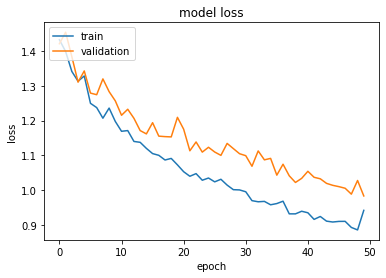

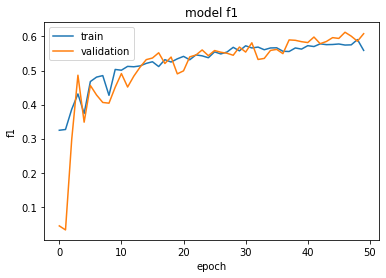

In [33]:
# Plotting train_loss and val_loss wrt epochs
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history1.history['f1'])
plt.plot(history1.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

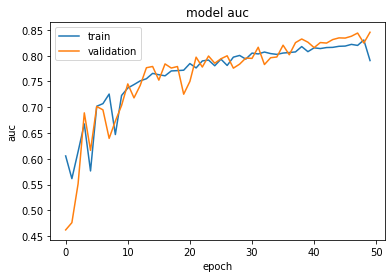

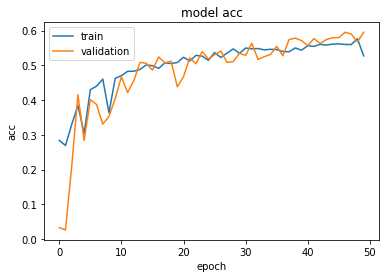

In [34]:

plt.plot(history1.history['auc'])
plt.plot(history1.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

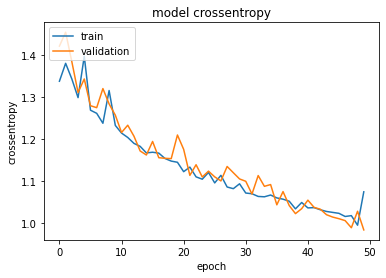

In [35]:
plt.plot(history1.history['categorical_crossentropy'])
plt.plot(history1.history['val_categorical_crossentropy'])
plt.title('model crossentropy')
plt.ylabel('crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

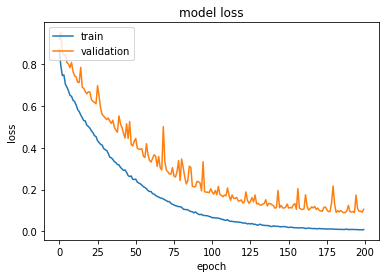

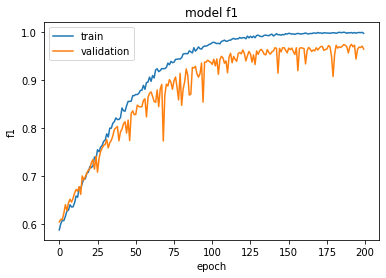

In [36]:
# Plotting train_loss and val_loss wrt epochs
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history2.history['f1'])
plt.plot(history2.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

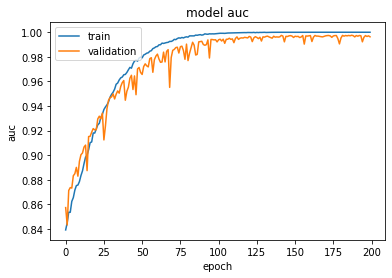

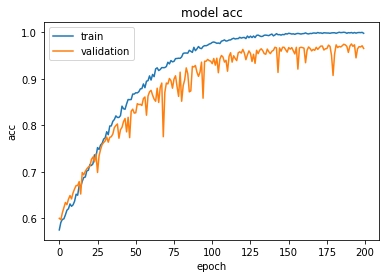

In [37]:
plt.plot(history2.history['auc'])
plt.plot(history2.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

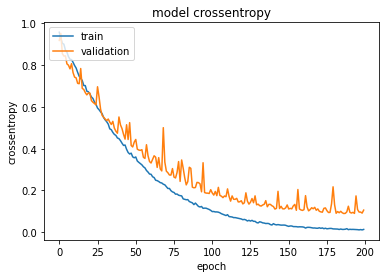

In [38]:
plt.plot(history2.history['categorical_crossentropy'])
plt.plot(history2.history['val_categorical_crossentropy'])
plt.title('model crossentropy')
plt.ylabel('crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [39]:
model.save("/content/drive/MyDrive/AML_proj_pics2/vgg16_4.h5")

In [40]:
model4=keras.models.load_model('/content/drive/MyDrive/AML_proj_pics2/vgg16_4.h5')

In [196]:
# Import the test data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/AML_proj_pics2/test",
    image_size=target,
    batch_size=batch,
    shuffle=False,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=autotune)
test_ds = test_ds.cache().prefetch(buffer_size=autotune)

Found 1280 files belonging to 4 classes.


In [197]:
model4.evaluate(test_ds)

40/40 [==============================] - 2s 50ms/step - loss: 1.5060 - auc: 0.8859 - f1: 0.6816 - acc: 0.7070 - categorical_crossentropy: 1.5060


[1.5060343742370605,
 0.8859343528747559,
 0.681571364402771,
 0.70703125,
 1.5060343742370605]

In [198]:
predictions=model4.predict(test_ds)

In [199]:
# list of number of images belonging to each class in test directory
test_images = []

for label in class_names:
    dir_name = "/content/drive/MyDrive/AML_proj_pics2/test/" + label
    test_images.append(len([name for name in os.listdir(dir_name)]))
test_images

[179, 12, 641, 448]

In [200]:
# targets list
targets=[]
for i in range(0, len(test_images)):
    targets+=[i]*test_images[i]
targets=np.asarray(targets)
test_images, class_names, targets

([179, 12, 641, 448],
 ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'],
 array([0, 0, 0, ..., 3, 3, 3]))

In [201]:
from sklearn.metrics import classification_report
print(classification_report(np.asarray(targets), np.argmax(predictions, axis=1), target_names=class_names))

                  precision    recall  f1-score   support

    MildDemented       0.86      0.17      0.28       179
ModerateDemented       0.67      0.33      0.44        12
     NonDemented       0.76      0.80      0.78       641
VeryMildDemented       0.63      0.80      0.71       448

        accuracy                           0.71      1280
       macro avg       0.73      0.53      0.55      1280
    weighted avg       0.73      0.71      0.68      1280



In [202]:
# generating predictions csv file
import pandas as pd
df=pd.DataFrame(columns=class_names)
for i in range(0, 4):
    df[class_names[i]]=predictions[:,i]

df

,MildDemented,ModerateDemented,NonDemented,VeryMildDemented
0,9.962243e-01,7.348955e-05,0.000356,0.003347
1,1.628692e-01,4.266958e-05,0.831966,0.005122
2,1.923601e-02,5.706971e-07,0.974740,0.006024
3,9.982473e-01,2.081609e-04,0.000081,0.001463
4,7.409617e-01,1.558185e-04,0.094758,0.164124
...,...,...,...,...
1275,6.763230e-09,1.155375e-11,0.993986,0.006014
1276,1.034004e-03,1.064925e-08,0.988133,0.010833
1277,1.046128e-08,2.589973e-08,0.808173,0.191827
1278,6.703048e-08,5.648787e-08,0.007042,0.992958


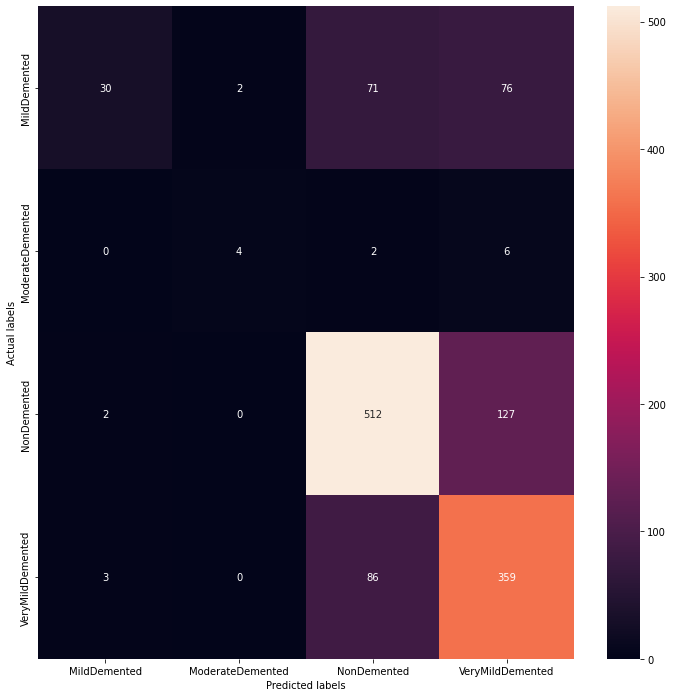

In [203]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
fig,ax = plt.subplots(figsize=(12,12))
sns.heatmap(confusion_matrix(np.asarray(targets), np.argmax(predictions, axis=1)),annot=True,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.show()

In [204]:
from keras.models import Model
import scipy as sp
gap_weights = model4.layers[-1].get_weights()[0]
gap_weights.shape

(512, 4)

In [205]:
preds=model4.predict(test_ds)

In [206]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 208, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 208, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 104, 88, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 104, 88, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 104, 88, 128)      1

In [207]:
cam_model  = Model(inputs=model4.input,outputs=(model4.layers[-13].output,model4.layers[-1].output))

In [208]:
features,results = cam_model.predict(test_ds)
features.shape

(1280, 52, 44, 256)

In [209]:
results

array([[9.9622428e-01, 7.3489551e-05, 3.5554258e-04, 3.3466949e-03],
       [1.6286922e-01, 4.2669584e-05, 8.3196586e-01, 5.1222015e-03],
       [1.9236006e-02, 5.7069707e-07, 9.7473973e-01, 6.0237236e-03],
       ...,
       [1.0461282e-08, 2.5899725e-08, 8.0817264e-01, 1.9182734e-01],
       [6.7030484e-08, 5.6487874e-08, 7.0419982e-03, 9.9295783e-01],
       [2.3963069e-09, 1.0164810e-09, 8.4998488e-02, 9.1500157e-01]],
      dtype=float32)

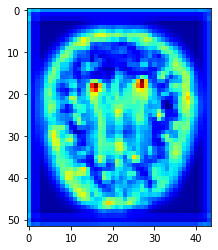

In [210]:
pic_sum=np.zeros((52,44))
for i in range(0,255):
  pic_sum=pic_sum+features[0, :, :, i]

avg_pic=pic_sum/4


plt.imshow(avg_pic, cmap='jet')


In [211]:
test_dir = '/content/drive/MyDrive/AML_proj_pics2/test'
categories_test = os.listdir(test_dir)
labels = [i for i in range(len(categories_test))]
labelDict_test = dict(zip(categories_test,labels))

In [212]:
import cv2

In [213]:
data_test = []
target_test = []
imgs_path=[]

for c in categories_test:
    c_join = os.path.join(test_dir,c)
    #print(c_join)
    train_img = os.listdir(c_join)
    #print(train_img)
    
    for img in train_img:
        img_join = os.path.join(c_join,img)
        imgs_path.append(img_join)
        temp = cv2.imread(img_join)
        
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        data_test.append(gray)
        
        target_test.append(labelDict_test[c])

In [214]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [228]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=1, i=i):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    print('Predicted class:' + str(list(labelDict_test.keys())[np.argmax(results[i])]),'\n' + 'Predicted probability:' + str(np.max(results[i])/np.sum(results[i])),'\n' + 'Actual class:', str(list(labelDict_test.keys())[target_test[i]]), '\n')

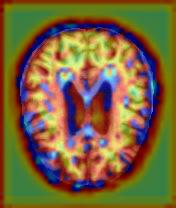

Predicted class: NonDemented , Predicted probability: 0.98724306 , Actual class: NonDemented 



In [216]:
save_and_display_gradcam(imgs_path[1279], avg_pic)

In [222]:
def display_images():
  rng = np.random.default_rng()
  rints = rng.integers(low=0, high=1280, size=5)
  
  pic_sum=np.zeros((52,44))

  for i in rints:
    pic_sum=np.zeros((52,44))
    for j in range(0,255):
      pic_sum=pic_sum+features[i, :, :, j]
      avg_pic=pic_sum/4
    save_and_display_gradcam(imgs_path[i],avg_pic, i=i)

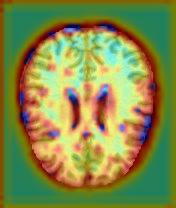

Predicted class:NonDemented 
Predicted probability:0.99597627 
Actual class: NonDemented 



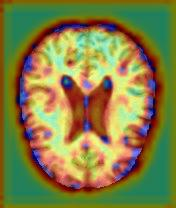

Predicted class:NonDemented 
Predicted probability:0.9998022 
Actual class: NonDemented 



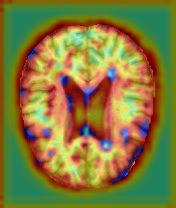

Predicted class:NonDemented 
Predicted probability:0.99998885 
Actual class: NonDemented 



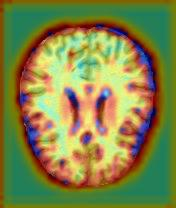

Predicted class:NonDemented 
Predicted probability:0.9986249 
Actual class: NonDemented 



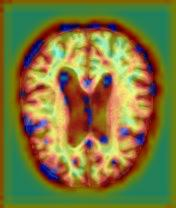

Predicted class:VeryMildDemented 
Predicted probability:0.6205439 
Actual class: MildDemented 



In [233]:
display_images()